# The Ultimate Graduate Admissions EDA (Version 0.7)

Even the most qualified and confident applicants worry about getting into grad school. Unfortunately, grad school admissions statistics tend to be more difficult to find than undergrad acceptance rates.

Here, we're using data from two datasets. The first one is [GradCafe_data](https://github.com/deedy/gradcafe_data) that was scraped from [this](https://www.thegradcafe.com/) website which is a database of over 500,000 *user-submitted* admission results. And the second being ['Graduate Admissions dataset'](https://www.kaggle.com/mohansacharya/graduate-admissions) submitted by user Mohan Acharya. It's a tidy set of 500 data points with features such as gre, toefl, cgpa, sop scores.

__Few things to note before we start:__

In the grad_cafe dataset self-reported candidates are likelier to post when they are accepted and they're likely to post results for multiple applications. The data in no means is perfect, but we can get some interesting insights anyway.

In the Graduate Admissions dataset, the data very is likely representative of indian applicants as hinted in the overview section [here](https://www.kaggle.com/mohansacharya/graduate-admissions/home).


In [1]:
import pandas as pd
import numpy as np
import pickle
import math

from wordcloud import WordCloud
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import figure, style
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

pd.set_option('display.max_columns', 30)
style.reload_library()

## Analyzing Gradcafe data

In [2]:
# importing gradcafe data
df = pd.read_csv("D:\\DataSets\\git_grad_admiss\\clean_data.csv", index_col=0)

C:\Users\Aakash\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (4,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Clean data once and save to csv to avoid wasting time on the process every time we run the file.

In [3]:
# One time cleaning data set

# df.drop('row_id', axis=1, inplace=True)
# df.drop(['decision_timestamp', 'post_timestamp'], axis=1, inplace=True)
# df['decision_date'] = pd.to_datetime(df['decision_date'].str.replace(r'[()]', ''), errors='coerce')
# df['post_date'] = pd.to_datetime(df['post_date'].str.replace(r'[()]', ''),  errors='coerce')

df.to_csv("D:\\DataSets\\git_grad_admiss\\clean_data.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271807 entries, 0 to 271806
Data columns (total 16 columns):
uni_name           271676 non-null object
major              271802 non-null object
degree             271807 non-null object
season             221909 non-null object
decision           271418 non-null object
decision_method    271399 non-null object
decision_date      271634 non-null object
ugrad_gpa          58155 non-null float64
gre_verbal         62769 non-null float64
gre_quant          62769 non-null float64
gre_writing        60293 non-null float64
is_new_gre         62769 non-null object
gre_subject        9304 non-null float64
status             253605 non-null object
post_date          271807 non-null object
comments           165402 non-null object
dtypes: float64(5), object(11)
memory usage: 35.3+ MB


## Using the applicants comments

We can use the comments data to create a word cloud to see what is being discussed most frequently.

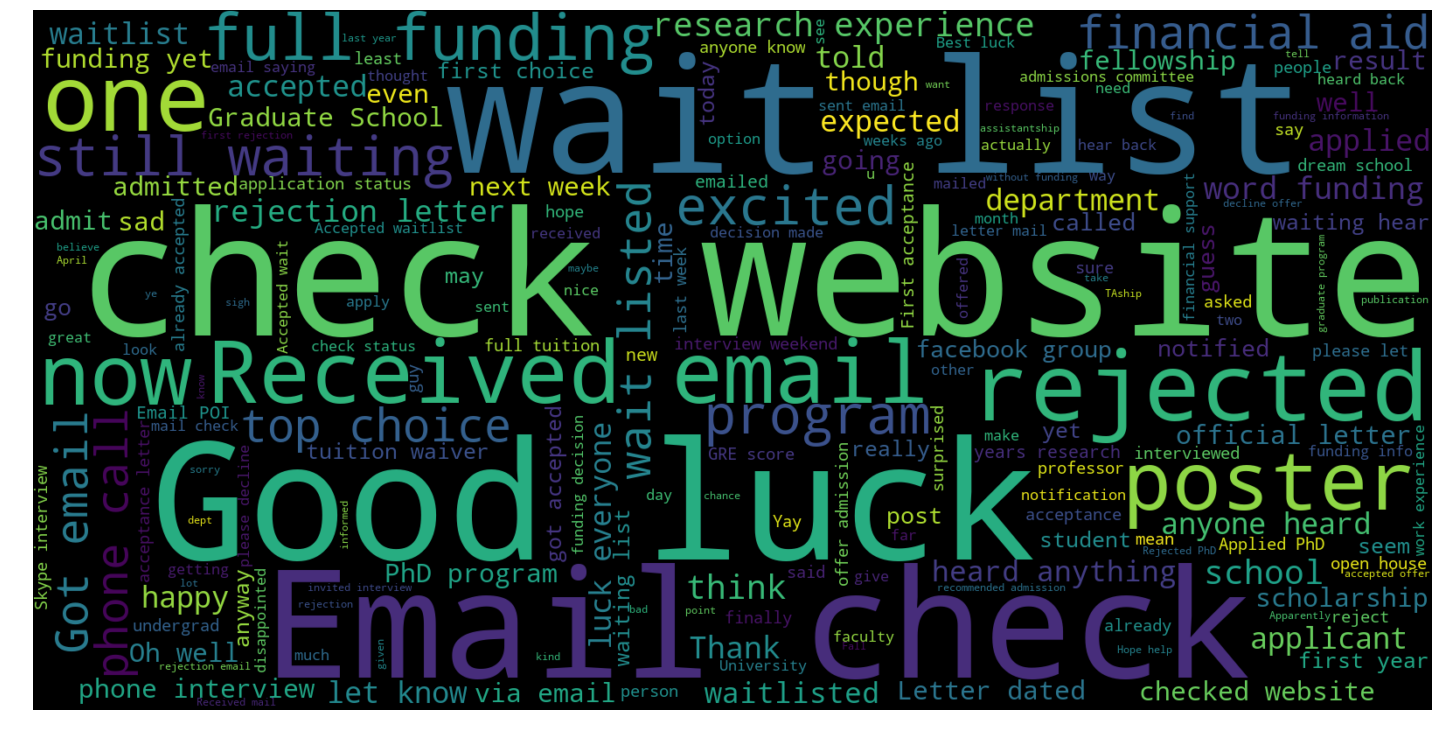

In [5]:
def create_wordcloud():
    # Create the wordcloud object
    
    wordcloud = WordCloud(width=1600, height=800).generate(' '.join(df['comments'].fillna('')))

    # Display the generated image:
    plt.figure( figsize=(20,10) )
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.tight_layout(pad=0)
    plt.show()
    
create_wordcloud()

## Top Majors, Degrees and Status Types

In [6]:
# Top 10 Majors
print(df['major'].value_counts().head(10))

perc = (len(df[df['major']=='Computer Science']) + len(df[df['major']=='Economics']))/len(df)
print(f"\nComputer Science and Economics majors combined make up for {round(perc*100, 2)} percent of the crowd.")

Computer Science             14552
Economics                    13377
English                       9936
Philosophy                    8793
Physics                       6792
Clinical Psychology           6264
Political Science             6054
Mathematics                   5110
Sociology                     4871
Speech Language Pathology     4845
Name: major, dtype: int64

Computer Science and Economics majors combined make up for 10.28 percent of the crowd.


In [7]:
# Top Degrees
print(df['degree'].value_counts())

rest = len(df[(df['degree'] != 'PhD') & (df['degree'] != 'MS')])
phd = len(df[(df['degree'] == 'PhD')])/rest
ms = len(df[(df['degree'] == 'MS')])/rest


print(f"\n\nratio of PhD : MS : rest\n\t  {round(phd)} : {round(ms)} : 1")

PhD      176983
MS        85501
Other      4946
MFA        4060
MBA         193
MA          114
MEng         10
Name: degree, dtype: int64


ratio of PhD : MS : rest
	  19 : 9 : 1


In [8]:
# Statuses
print(df['status'].value_counts())
print("\nMost of the data we have is from Americans applying to American Universities, "
      "with the number of international students being only half of that.")

American                        144561
International                    76047
International with US Degree     25867
Other                             7130
Name: status, dtype: int64

Most of the data we have is from Americans applying to American Universities, with the number of international students being only half of that.


In [9]:
# Count of Decisions
df['decision'].value_counts()

Accepted       115035
Rejected       101311
Other           19889
Interview       17778
Wait listed     17405
Name: decision, dtype: int64

We'll club all decisions that are not *accepted* or *rejected* as *under process*.

In [10]:
df.loc[(df['decision'] != 'Accepted') & (df['decision'] != 'Rejected'), 'decision'] = 'In process'
df['decision'].value_counts()

Accepted      115035
Rejected      101311
In process     55461
Name: decision, dtype: int64

One of the columns has a binary feature called 'is_new_gre' to differentiate the candidates with different gre evaluation scales (Old and New). We'll be using just the new scores to avoid complexity.

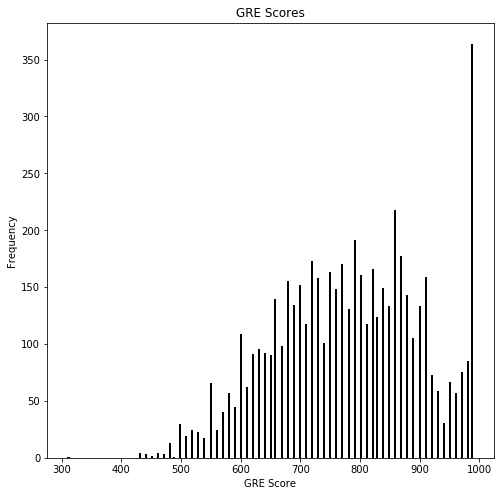

Many scores are close to 1000. This is possibly because we've used the feature 'gre_subject' which may be a subject specific test with a different score metric.


In [11]:
# Distribution of GRE Scores

df["gre_subject"][df["is_new_gre"] == True].plot(kind = 'hist',bins = 200,figsize = (8,8), color='k')
plt.title("GRE Scores")
plt.xlabel("GRE Score")
plt.ylabel("Frequency")
plt.show()

print("Many scores are close to 1000. This is possibly because we've used the feature 'gre_subject'\
 which may be a subject specific test with a different score metric.")

We'll make a __gre_total__ feature instead, by combining all the individual scores.

In [12]:
# Creating a true GRE total feature 
df['gre_total'] = df['gre_verbal'] + df['gre_quant'] + df['gre_writing'] 

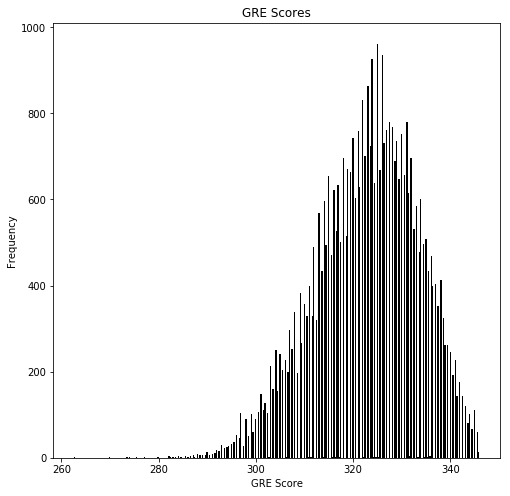

The new GRE has a max score of 340, but here we can see that a few scores exceed 340. If we choose to drop these values we
would be losing around 7.25 percent of GRE data. We'll choose to discard the data.


In [13]:
# Distribution of GRE Scores

plt.figure(figsize=(12, 10))
df["gre_total"][df["is_new_gre"] == True].plot(kind = 'hist', bins=300, figsize = (8,8), color='k')
plt.title("GRE Scores")
plt.xlabel("GRE Score")
plt.ylabel("Frequency")
plt.show()

print("The new GRE has a max score of 340, but here we can see that a few scores exceed 340. "
      "If we choose to drop these values we\nwould be losing around "
      f"{round((len(df[df['gre_total'] > 340])/len(df['gre_total']))*100, 2)} percent of GRE data. "
      "We'll choose to discard the data.")

In [14]:
# dropping incorrect gre scores
df = df[df['gre_total'] <= 340]

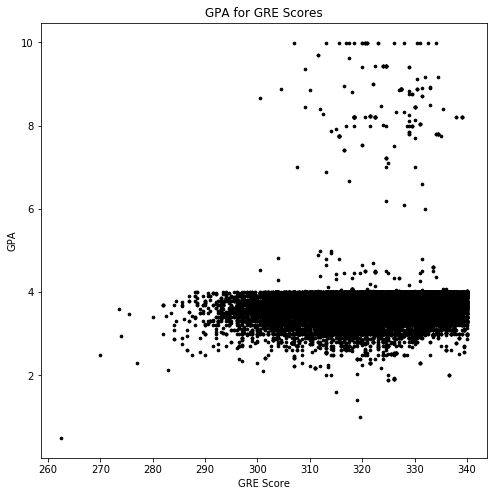

While most people have entered gpa out of 4, a few people didn't get the memo and entered a CGPA out of 10


In [15]:
# GRE score vs GPA scatter plot

plt.figure(figsize=(8, 8))
plt.scatter(df["gre_total"][df["is_new_gre"] == True], df["ugrad_gpa"][df["is_new_gre"] == True], s=7, color='k')
plt.title("GPA for GRE Scores")
plt.xlabel("GRE Score")
plt.ylabel("GPA")
plt.show()

print("While most people have entered gpa out of 4, a few people didn't get the memo and entered a CGPA out of 10")

Here's what our plot looks like by only including applicants between 2 and 4 gpa.


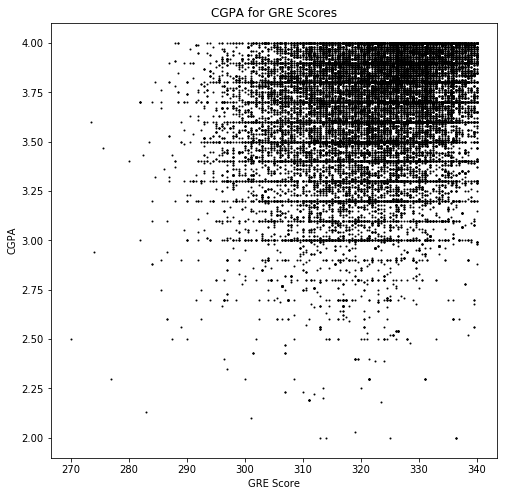

In [16]:
# GRE score vs GPA scatter plot
print("Here's what our plot looks like by only including applicants between 2 and 4 gpa.")

plt.figure(figsize=(8, 8))
plt.scatter(df["gre_total"][df['ugrad_gpa'] <= 4.0][df['ugrad_gpa'] >= 2.0][df["is_new_gre"] == True], 
            df['ugrad_gpa'][df['ugrad_gpa'] <= 4.0][df['ugrad_gpa'] >= 2.0][df["is_new_gre"] == True],
           s=1, color='k')
plt.title("CGPA for GRE Scores")
plt.xlabel("GRE Score")
plt.ylabel("CGPA")
plt.show()



__P.S:__ Its entirely possible we've included applicants with a *low CGPA* on the 10 point scale. But there's not much we can do about that.

C:\Users\Aakash\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


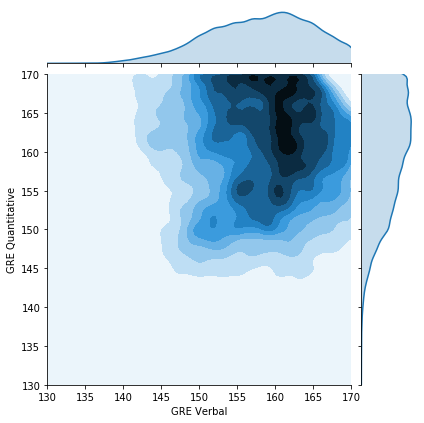

In [17]:
def verbal_quant_jointplot():
    grev = df['gre_verbal'][df['ugrad_gpa'] <= 4.0][df['ugrad_gpa'] >= 2.0][df['is_new_gre'] == True]
    grem = df['gre_quant'][df['ugrad_gpa'] <= 4.0][df['ugrad_gpa'] >= 2.0][df['is_new_gre'] == True]
    ax = sns.jointplot(grev, grem, stat_func=None, kind='kde', size=6, xlim=(130,170), ylim=(130,170))
    ax.set_axis_labels('GRE Verbal','GRE Quantitative')
    plt.show()
    
verbal_quant_jointplot()

Here we can see GRE Quantitative scores going all the way upto the max possible (170), most applicants having quant scores in the 160-170 range. Verbal scores seems relatively high as well.

C:\Users\Aakash\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


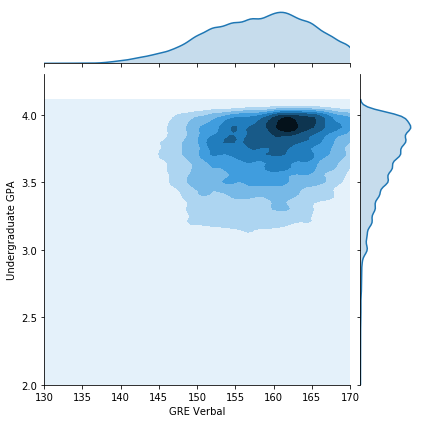

In [18]:
def verbal_gpa_jointplot():
    grev = df['gre_verbal'][df['ugrad_gpa'] <= 4.0][df['ugrad_gpa'] >= 2.0][df['is_new_gre'] == True]
    gpa = df['ugrad_gpa'][df['ugrad_gpa'] <= 4.0][df['ugrad_gpa'] >= 2.0][df['is_new_gre'] == True]
    ax = sns.jointplot(grev, gpa, stat_func=None, kind='kde', size=6, xlim=(130,170), ylim=(2,4.3))
    ax.set_axis_labels('GRE Verbal','Undergraduate GPA')
    plt.show()
    
verbal_gpa_jointplot()

It looks like almost all candidates have their gpa between 3.5 and 4. Graduate schools, particularly PhD programs, tend to have a minimum GPA cutoff for applicants usually around the 3.5 area.

## Competition in Top Universities

Bubble plot showing the average level of candidates applying, grouped by University. The size of the bubbles indicates the number of applications to that perticular uni. The Color indicates average total GRE score for those applicants.


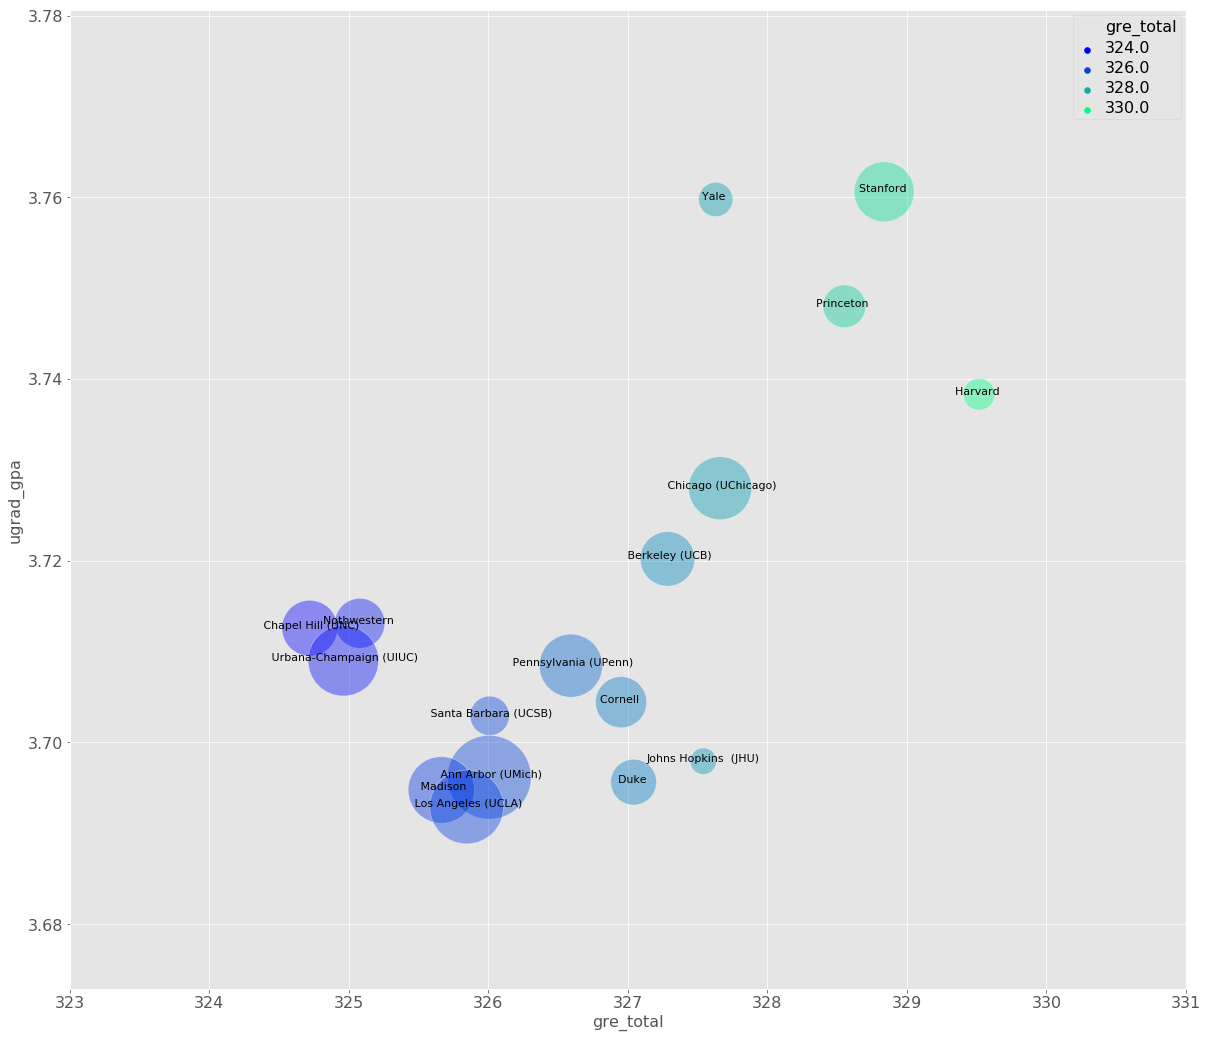

In [106]:
def top_uni_applied(count=5, x='gre_total', major=None):
    '''
    Function that plots a feature against gpa, grouped by Universities, aggregated by mean score of all applied,
    and sorted by Rank.
    Returns a list of all Universities ordered by rank. This list is used for the top_uni_accepted() function.
    '''
    
    scaler = MinMaxScaler((0.1, 1))
    uni_list = df[df['ugrad_gpa'] <= 4.0][df['ugrad_gpa'] >= 2.0][df['is_new_gre'] == True]
    
    if major:
        uni_list = uni_list[uni_list['major'] == major]

    uni_list = uni_list.groupby(['uni_name']).agg({'decision':'count', 'gre_total':'mean', 'ugrad_gpa':'mean', 'gre_verbal':'mean', 'gre_quant': 'mean'})
    uni_list = uni_list[uni_list['decision'] > (uni_list['decision'].mean() if major else 150)].sort_values(['ugrad_gpa', x], ascending=False)
    uni_list.rename(columns={'decision': 'entries'}, inplace=True)
    uni_list.reset_index(inplace=True)
    ranked_uni_list = uni_list.uni_name.tolist()
    uni_list = uni_list.head(count)
    s = scaler.fit_transform(uni_list.entries.values.reshape(-1, 1))
    
    with open("ranked_uni_list.pickle", "wb") as f:
        pickle.dump(ranked_uni_list, f)
    
    #Create figure
    with plt.style.context('ggplot'):
        
        plt.figure(figsize = (20, 18))
        cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
        
        if x == 'gre_quant':
            score_hue = uni_list.gre_verbal
        
        elif x == 'gre_verbal':
            score_hue = uni_list.gre_quant
            
        else:
            score_hue = uni_list.gre_total

        # Create scatterplot. alpha controls the opacity and s controls the size.
        ax = sns.scatterplot(uni_list[x], uni_list.ugrad_gpa, alpha=0.4, s=s*7000, hue=score_hue, palette='winter')

        xstart = math.floor(uni_list[x].min() - 1)
        xend = math.ceil(uni_list[x].max() + 1)
        ystart = uni_list.ugrad_gpa.min() - 0.02
        yend = uni_list.ugrad_gpa.max() + 0.02
        
        ax.set_xlim(xstart, xend)
        ax.set_ylim(ystart, yend)
        

        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                     ax.get_xticklabels() + ax.get_yticklabels() + ax.get_legend().get_texts()):
            item.set_fontsize(16)


        #For each point, we add a text inside the bubble
        for line in range(0, uni_list.shape[0]):
            ax.text(uni_list[x][line], uni_list.ugrad_gpa[line], uni_list.uni_name[line].replace('University Of', '').replace('University', '').split(',')[-1]  ,
                    horizontalalignment='center', 
                       size='small', color='black', fontsize=11)
        
    return ranked_uni_list     

print("Bubble plot showing the average level of candidates applying, grouped by University. "
        "The size of the bubbles indicates the number of applications to that perticular uni. "
        "The Color indicates average total GRE score for those applicants.")

ranked_uni_list = top_uni_applied(count=17, x='gre_total', major=None)

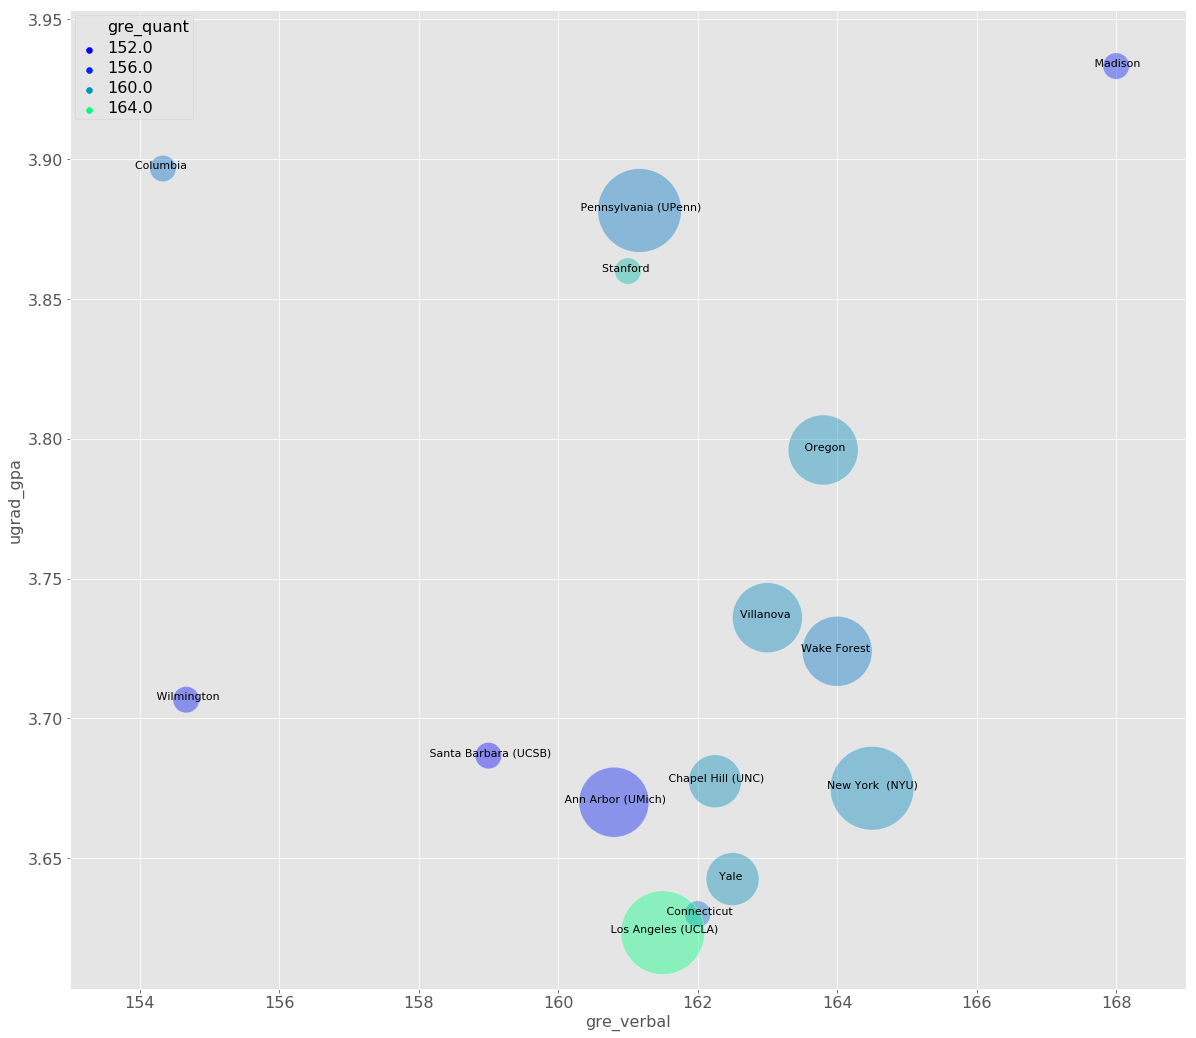

In [105]:
_ = top_uni_applied(count=15, x='gre_verbal', major='Psychology')

Psychology students are expected to have a higher verbal score without too much leniancy on quant. Although Stanford and UPenn applicants have pretty good quant scores.

When we split the applicants by accepted and reject, we can see how much difference there is between them.


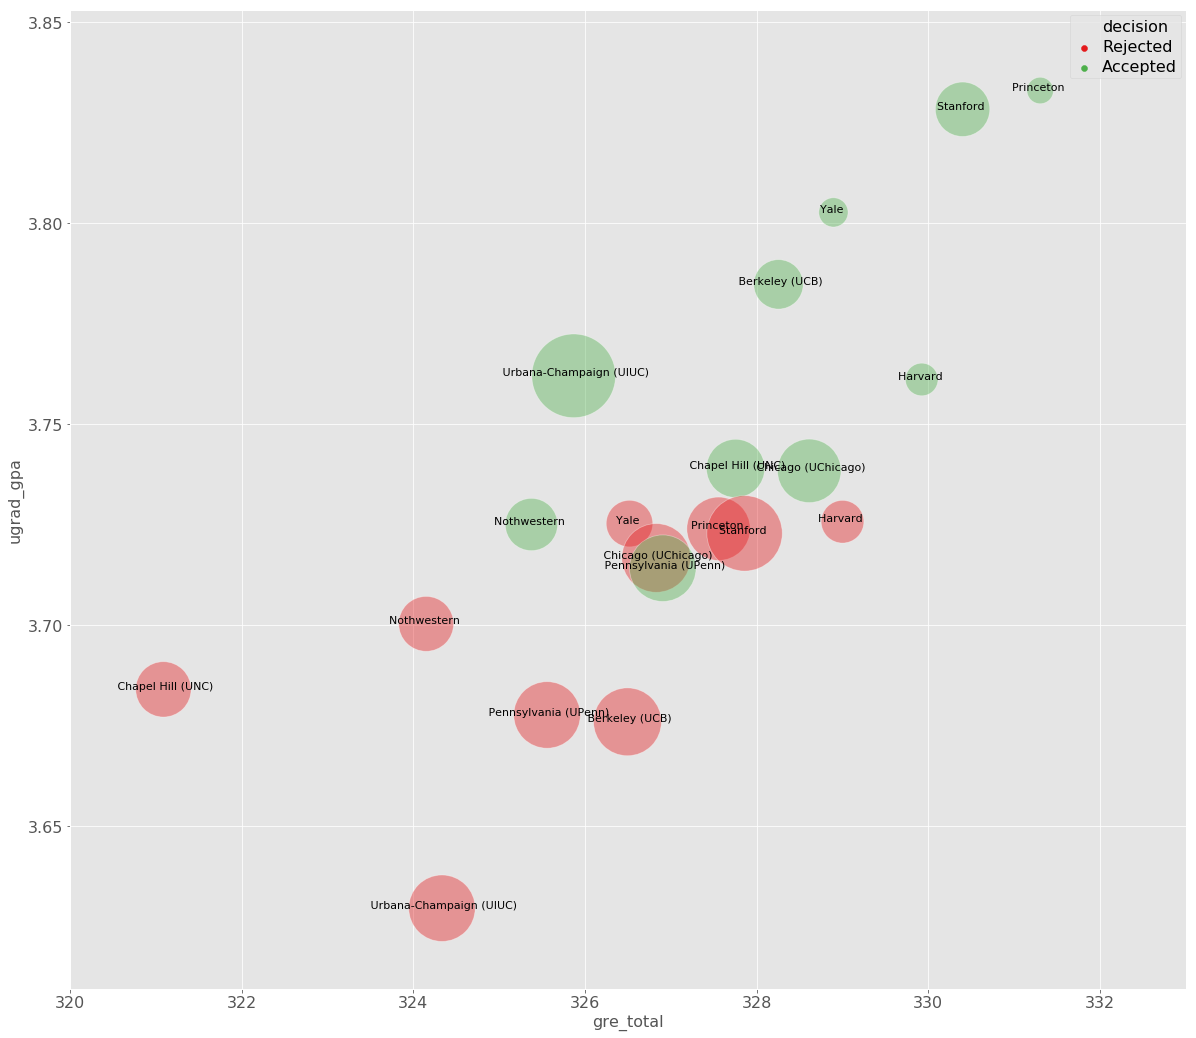

In [87]:
 def top_uni_accepted(count=5, x='gre_total', major=None, ranked_uni_list=ranked_uni_list):
        
    if not ranked_uni_list:
        with open("ranked_uni_list.pickle", "rb") as f:
            ranked_uni_list = pickle.load(f)

    scaler = MinMaxScaler((0.1, 1))
    uni_list = df[df['ugrad_gpa'] <= 4.3][df['ugrad_gpa'] >= 2.0][df['is_new_gre'] == True][df['decision'] != 'In process']

    if major:
        uni_list = uni_list[uni_list['major'] == major]

    uni_list = uni_list.groupby(['uni_name', 'decision']).agg({'decision':'count', 'gre_total':'mean', 'ugrad_gpa':'mean', 'gre_verbal':'mean', 'gre_quant': 'mean'})
    uni_list = uni_list.sort_values(['ugrad_gpa', x], ascending=False)
    uni_list.rename(columns={'decision': 'entries'}, inplace=True)
    uni_list.reset_index(inplace=True)
    uni_list = uni_list[uni_list['uni_name'].isin(ranked_uni_list[:count])]
    uni_list = uni_list.reset_index().drop('index', axis=1)
    s = scaler.fit_transform(uni_list.entries.values.reshape(-1, 1))
    
    
    #Create figure
    with plt.style.context('ggplot'):
        
        plt.figure(figsize = (20, 18))

        # Create scatterplot. alpha controls the opacity and s controls the size.
        ax = sns.scatterplot(uni_list[x], uni_list.ugrad_gpa, alpha=0.4, s=s*7000, hue=uni_list.decision, 
                             hue_order=['Rejected','', 'Accepted'], palette='Set1')

        xstart = math.floor(uni_list[x].min() - 1)
        xend = math.ceil(uni_list[x].max() + 1)
        ystart = uni_list.ugrad_gpa.min() - 0.02
        yend = uni_list.ugrad_gpa.max() + 0.02
        
        ax.set_xlim(xstart, xend)    
        ax.set_ylim(ystart, yend)


        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                     ax.get_xticklabels() + ax.get_yticklabels() + ax.get_legend().get_texts()):
            item.set_fontsize(16)


        #For each point, we add a text inside the bubble
        for line in range(0, uni_list.shape[0]):

            ax.text(uni_list[x][line], uni_list.ugrad_gpa[line], uni_list.uni_name[line].replace('University Of', '').replace('University', '').split(',')[-1]  ,
                    horizontalalignment='center', 
                       size='small', color='black', fontsize=11)

print("When we split the applicants by accepted and reject, we can see how much difference there is between them.")            
top_uni_accepted(count=10, x='gre_total')

Accepted/Rejected split for Economics Major


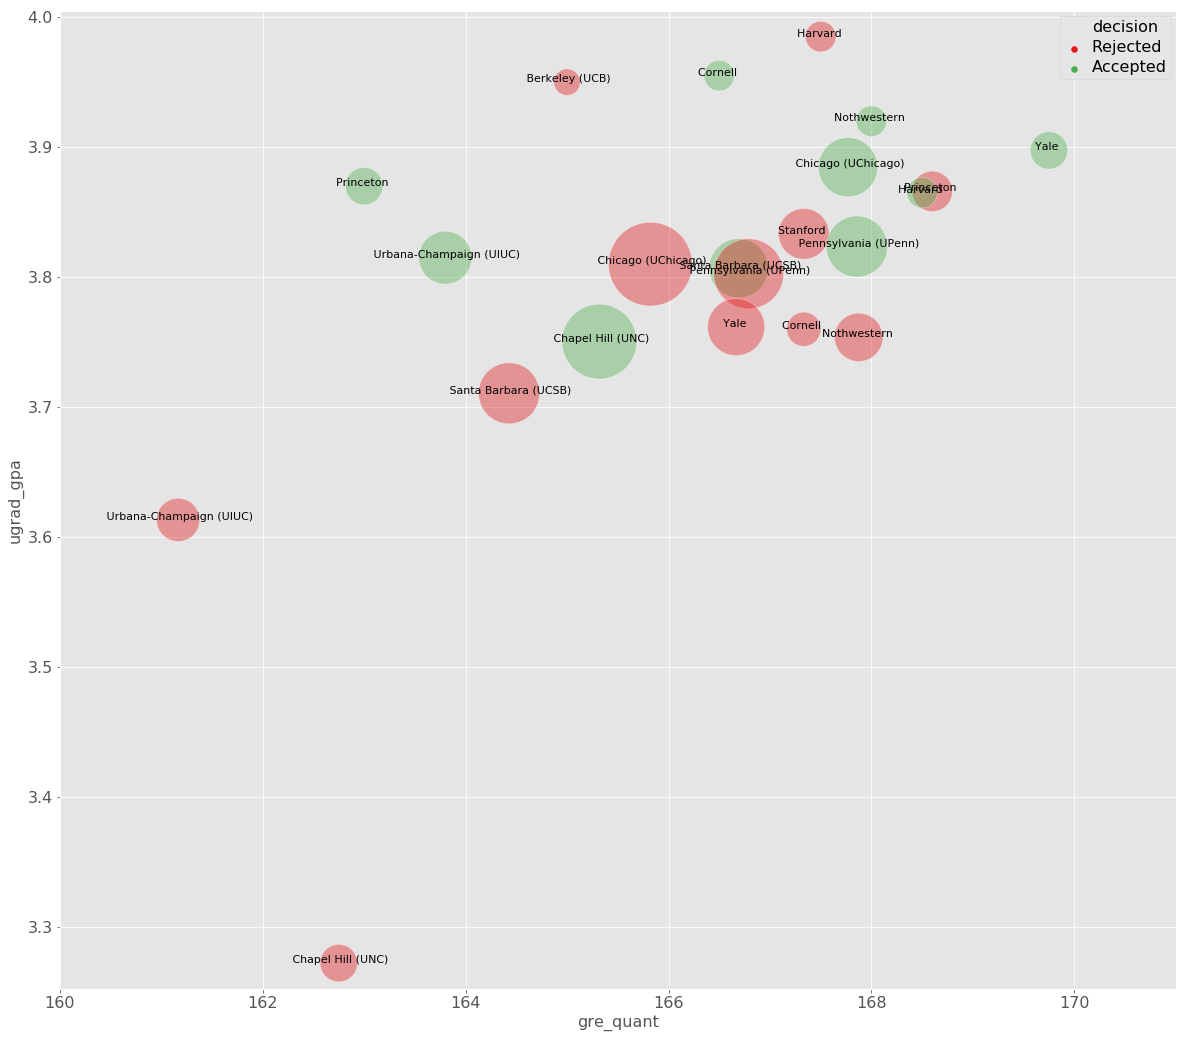

In [88]:
top_uni_accepted(count=12, x='gre_quant', major='Economics')
print("Accepted/Rejected split for Economics Major")

Split by status of applicants accepted by their respective Unis. This visual is pretty interesting. All three statuses seem to form their own group, with there being some intersection between Americans and International applicants with US Degrees.


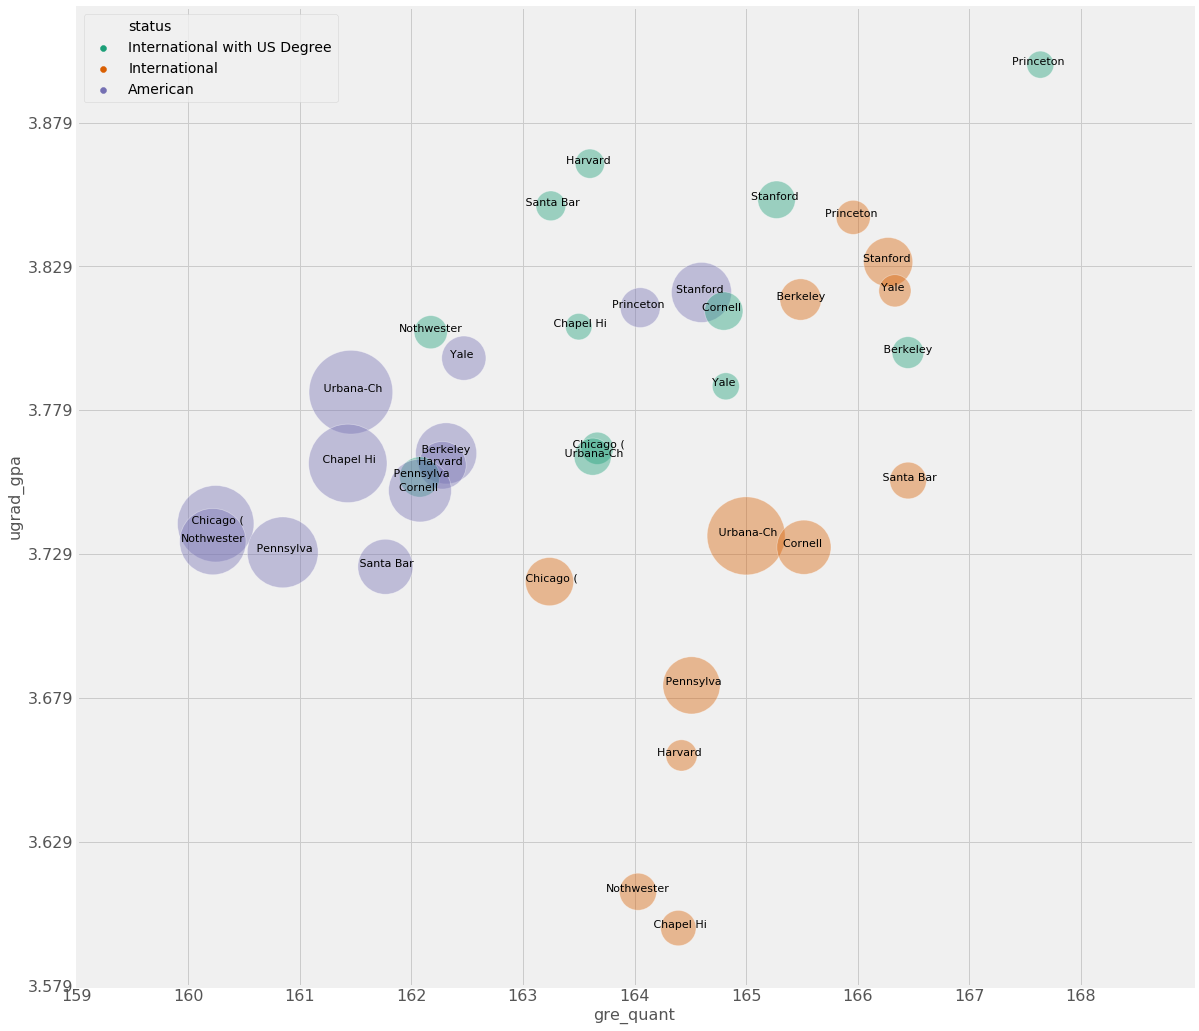

In [91]:
def top_uni_status(count=5, x='gre_verbal', major=None):   
    
    scaler = MinMaxScaler((0.1, 1))
    uni_list = df[df['ugrad_gpa'] <= 4.3][df['ugrad_gpa'] >= 2.0][df['is_new_gre'] == True][df['decision'] == 'Accepted'][df['status'] != 'Other']

    if major:
        uni_list = uni_list[uni_list['major'] == major]

    uni_list = uni_list.groupby(['uni_name', 'status']).agg({'status':'count', 'gre_total':'mean', 'ugrad_gpa':'mean', 'gre_verbal':'mean', 'gre_quant': 'mean'})
    uni_list = uni_list.sort_values(['ugrad_gpa', x], ascending=False)
    uni_list.rename(columns={'status': 'entries'}, inplace=True)
    uni_list.reset_index(inplace=True)
    uni_list = uni_list[uni_list['uni_name'].isin(ranked_uni_list[:count])]
    uni_list = uni_list.reset_index().drop('index', axis=1)
    s = scaler.fit_transform(uni_list.entries.values.reshape(-1, 1))
    
    
    #Create figure
    with plt.style.context('ggplot'):
        
        plt.figure(figsize = (20, 18))
        style.use(['fivethirtyeight'])


        # Create scatterplot. alpha controls the opacity and s controls the size.
        ax = sns.scatterplot(uni_list[x], uni_list.ugrad_gpa, alpha=0.4, s=s*7000, hue=uni_list.status,
                             hue_order=['International with US Degree', 'International', 'American'], palette='Dark2')

        xstart = math.floor(uni_list[x].min() - 1)
        xend = math.ceil(uni_list[x].max() + 1)
        ystart = uni_list.ugrad_gpa.min() - 0.02
        yend = uni_list.ugrad_gpa.max() + 0.02
        
        ax.set_xlim(xstart, xend)
        ax.xaxis.set_ticks(np.arange(xstart, xend, 1))
        
        ax.set_ylim(ystart, yend)
        ax.yaxis.set_ticks(np.arange(ystart, yend, 0.05))
        

        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                     ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(16)


        #For each point, we add a text inside the bubble
        for line in range(0, uni_list.shape[0]):

            ax.text(uni_list[x][line], uni_list.ugrad_gpa[line], uni_list.uni_name[line].replace('University Of', '').replace('University', '').split(',')[-1][:10]  ,
                    horizontalalignment='center', 
                       size='small', color='black', fontsize=11)

print("Split by status of applicants accepted by their respective Unis. This visual is pretty interesting. " 
      "All three statuses seem to form their own group, " 
"with there being some intersection between Americans and International applicants with US Degrees.")            
top_uni_status(count=12, x='gre_quant')

It looks like International students are judged significantly more on their GRE Quant scores than their gpa. On the other hand American students are given more weightage based on gpa than quant scores.

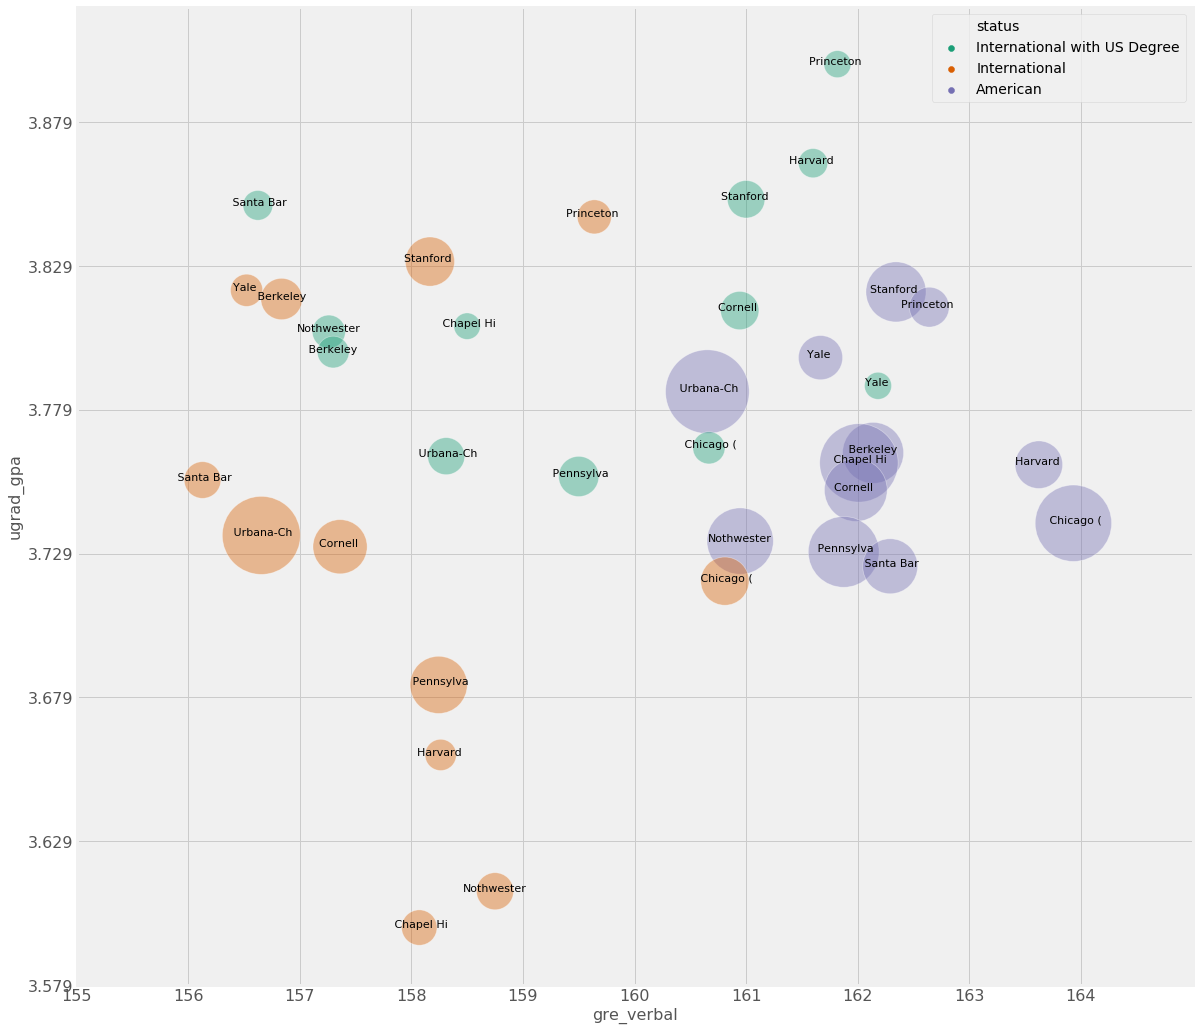

In [92]:
top_uni_status(count=12, x='gre_verbal')

International students also seem to have been given a pass on their gre Verbal scores. Overall it looks like a mixed bag for Int. students with US Degree. 

There's alot more analysis that can be done here by varying count, major, status, and degree specifically. But we'll stop here for now.

# Graduate Admissions Dataset 

This is the second dataset we'll work on. it has very few data points. but it has scores for all the tests one has to take to apply to Universities abroad. We'll analyze the data, and perform both, regression and classification to predict if one will be accepted into a university based on their scores.

In [25]:
df2 = pd.read_csv("D:\\DataSets\\grad_admiss_kaggle\\Admission_Predict_Ver1.1.csv")

In [26]:
df2.head()

,gre,toefl,uni_rating,sop,lor,cgpa,research,chance_of_admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


In [27]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
gre                500 non-null int64
toefl              500 non-null int64
uni_rating         500 non-null int64
sop                500 non-null float64
lor                500 non-null float64
cgpa               500 non-null float64
research           500 non-null int64
chance_of_admit    500 non-null float64
dtypes: float64(4), int64(4)
memory usage: 31.3 KB


### Applicants with/without Research Experience

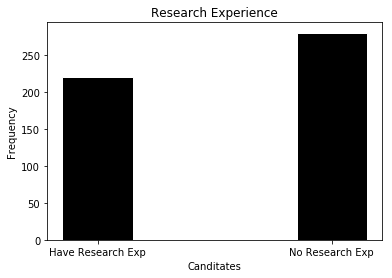

In [28]:
x = ['Have Research Exp', 'No Research Exp']
y = np.array([len(df2[df2.research == 0]),len(df2[df2.research == 1])])
plt.bar(x, y, width= 0.3, color='k', edgecolor='w')
plt.title("Research Experience")
plt.xlabel("Canditates")
plt.ylabel("Frequency")
plt.show()

In [29]:
df2.corr()

,gre,toefl,uni_rating,sop,lor,cgpa,research,chance_of_admit
gre,1.000000,0.827200,0.635376,0.613498,0.524679,0.825878,0.563398,0.810351
toefl,0.827200,1.000000,0.649799,0.644410,0.541563,0.810574,0.467012,0.792228
uni_rating,0.635376,0.649799,1.000000,0.728024,0.608651,0.705254,0.427047,0.690132
sop,0.613498,0.644410,0.728024,1.000000,0.663707,0.712154,0.408116,0.684137
lor,0.524679,0.541563,0.608651,0.663707,1.000000,0.637469,0.372526,0.645365
cgpa,0.825878,0.810574,0.705254,0.712154,0.637469,1.000000,0.501311,0.882413
research,0.563398,0.467012,0.427047,0.408116,0.372526,0.501311,1.000000,0.545871
chance_of_admit,0.810351,0.792228,0.690132,0.684137,0.645365,0.882413,0.545871,1.000000


### Heatmap of correlation matrix

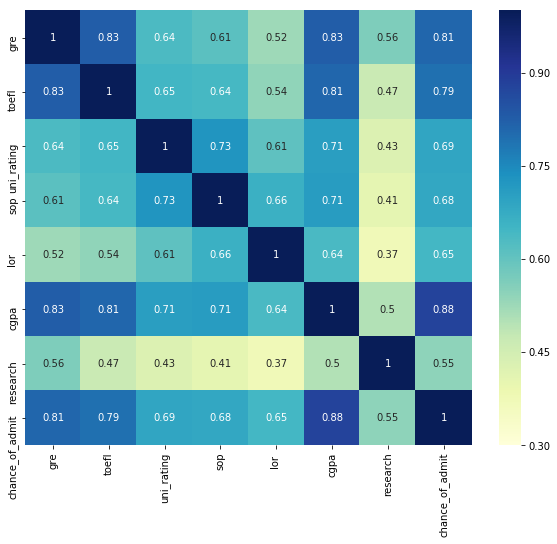

In [30]:
plt.figure(figsize=(10, 8))
style.use('fast')
sns.heatmap(df2.corr(), 0.3, 1, cmap="YlGnBu", annot=True)

Highest predictors of chance of admit are cgpa, gre, and toefl (and university rating to some extent)

### Distribution Plots

C:\Users\Aakash\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


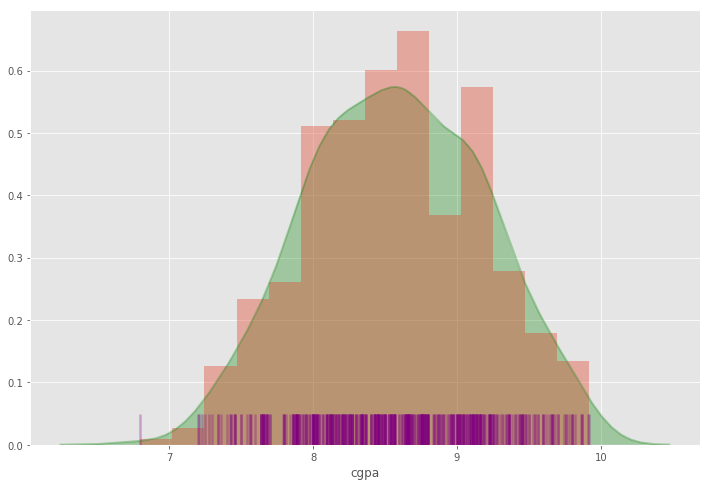

Distribution plot for cgpa shows us most people have their cgpa somewhere around 8.5-9 mark


In [31]:
def plot_dist(x=['cgpa']):
    
    for col in x:
        with plt.style.context('ggplot'):
            plt.figure(figsize = (12, 8))

            sns.distplot(df2[col], rug=True, norm_hist=False,
                        rug_kws={"color": "purple", "alpha":0.3, "linewidth": 2.5, "height":0.07},
                         kde_kws={"color": "g", "alpha":0.3, "linewidth": 2, "shade":True })

            plt.show()
        
plot_dist()
print("Distribution plot for cgpa shows us most people have their cgpa somewhere around 8.5-9 mark")

In [32]:
r_map = {
    1: 'y',
    0: 'n'
}

df2['research_y_n'] = df2['research'].map(r_map)


df2['accepted'] = 0
df2.loc[df2['chance_of_admit'] >= 0.8, 'accepted'] = 1

print("We've made a new column 'accepted' where all applicants with a chance of admit 0.8 and above are considered as accepted and the rest rejected.")
df2.head()

We've made a new column 'accepted' where all applicants with a chance of admit 0.8 and above are considered as accepted and the rest rejected.


,gre,toefl,uni_rating,sop,lor,cgpa,research,chance_of_admit,research_y_n,accepted
0,337,118,4,4.5,4.5,9.65,1,0.92,y,1
1,324,107,4,4.0,4.5,8.87,1,0.76,y,0
2,316,104,3,3.0,3.5,8.00,1,0.72,y,0
3,322,110,3,3.5,2.5,8.67,1,0.80,y,1
4,314,103,2,2.0,3.0,8.21,0,0.65,n,0


## Pairplot of most important features

C:\Users\Aakash\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Scatter plots of most important features against each other, with data points divided by whether a candidate has research experience.


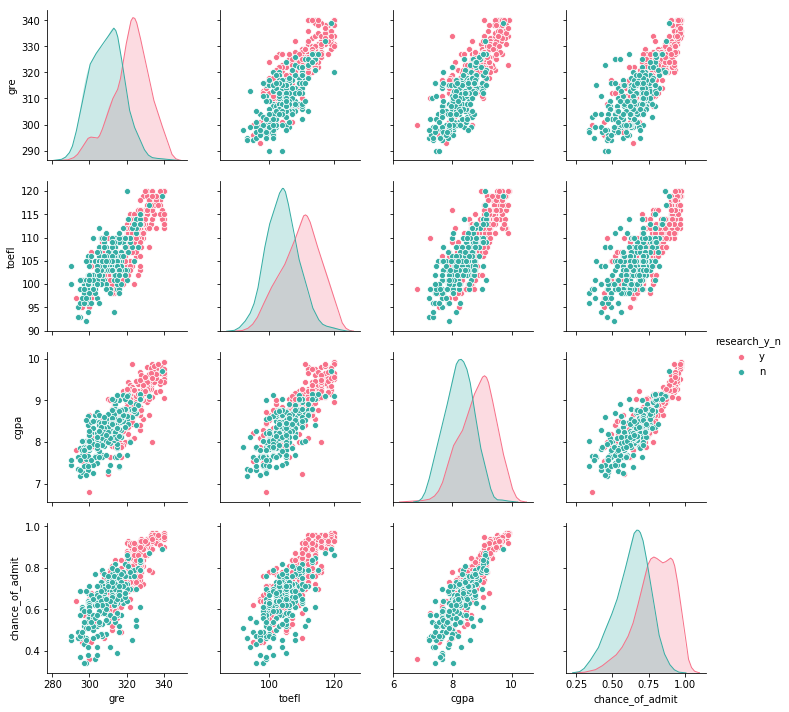

In [33]:
sns.pairplot(df2[['gre', 'toefl', 'cgpa', 'chance_of_admit', 'research_y_n']], kind='scatter',  
             hue='research_y_n', palette="husl", diag_kind='kde',
             diag_kws={'shade':True, 'linewidth': 1})

print("Scatter plots of most important features against each other, " 
      "with data points divided by whether a candidate has research experience.")

Its clear that in all fronts, applicants with research experience stand out with higher scores in all fronts, and thus are more likely to be accepted into uni. Some of the interesting plots we could focus on are: 

#### cgpa vs chance of admit (How important is your cgpa?)

#### lor vs uni rating (Do LORs from better Universities score better?)

#### toefl vs sop (Does doing well in your English language evaluation help writing a better SOP?)

C:\Users\Aakash\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 720x576 with 0 Axes>

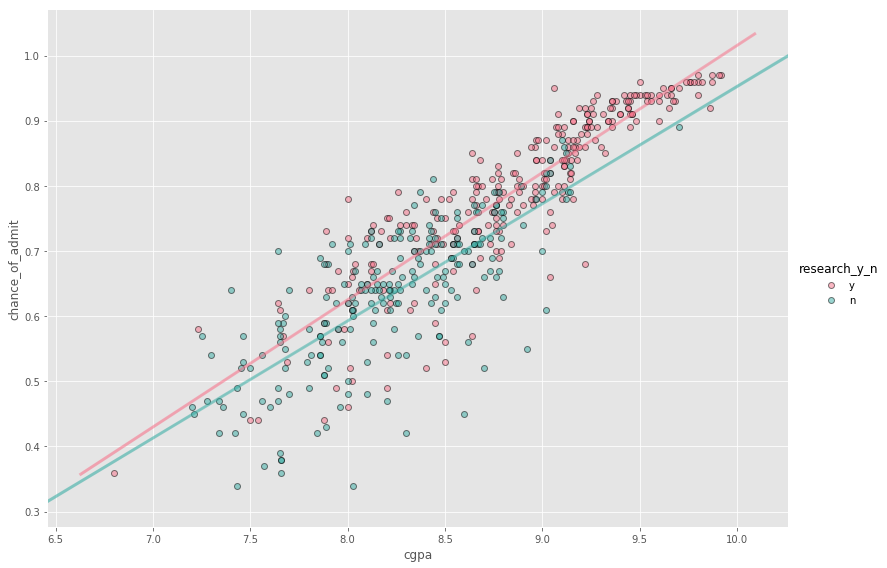

<Figure size 864x576 with 0 Axes>

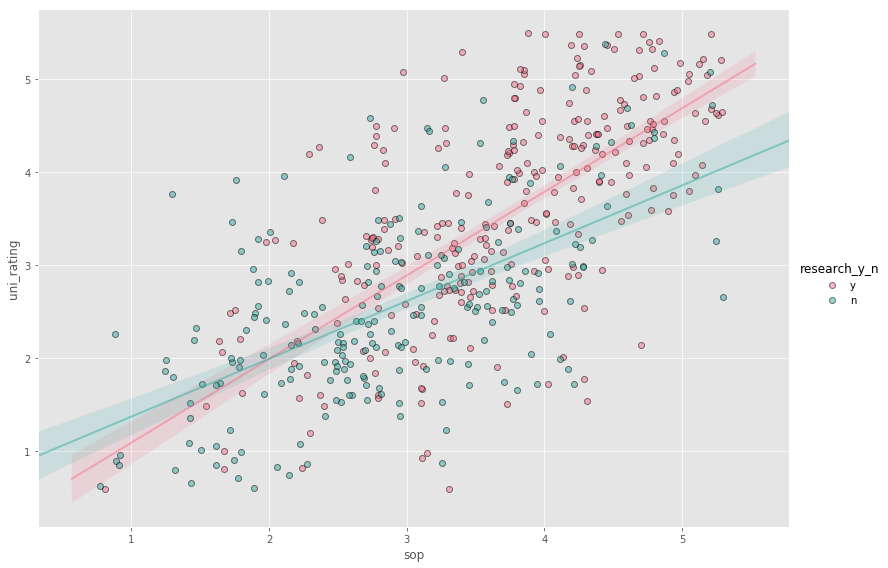

<Figure size 720x576 with 0 Axes>

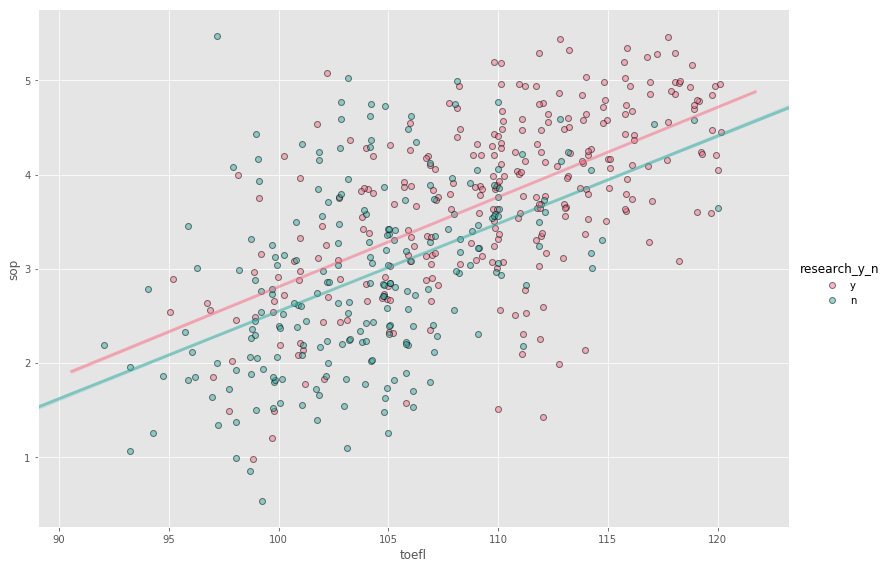

In [34]:
def plot_key():

    with plt.style.context('ggplot'):
        plt.figure(figsize = (10, 8))
        sns.lmplot( x="cgpa", y="chance_of_admit", data=df2, hue='research_y_n', ci=10,  height= 8, aspect=1.4,
                   palette="husl",
                   scatter_kws=dict(alpha=0.5, edgecolors="black"), 
                   line_kws={"alpha":0.5,"lw":3})
        plt.show()


        plt.figure(figsize = (12, 8))
        sns.lmplot( x="sop", y="uni_rating", data=df2, hue='research_y_n', ci=90, x_jitter=0.3, y_jitter=0.5, height= 8, aspect=1.4,
                   palette="husl",
                   scatter_kws=dict(alpha=0.5, edgecolors="black"), 
                   line_kws={"alpha":0.5,"lw":2})
        plt.show()


        plt.figure(figsize = (10, 8))
        sns.lmplot( x="toefl", y="sop", data=df2, hue='research_y_n', ci=10, x_jitter=0.3, y_jitter=0.5, height= 8, aspect=1.4,
                   palette="husl",
                   scatter_kws=dict(alpha=0.5, edgecolors="black"), 
                   line_kws={"alpha":0.5,"lw":3})
        plt.show() 
    
plot_key()

## Regression Modelling

From the correlation matrix we found the most important predictors of 'chance_of_admit' to be CGPA, GRE score, TOEFL score. 

In [35]:
main_df = df2[['cgpa', 'gre', 'toefl', 'chance_of_admit']]

In [36]:
X = main_df.drop('chance_of_admit', axis=1)
y = main_df['chance_of_admit']
col = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [37]:
def scale_features(X_train, X_test, col):

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train, columns=col)

    X_test = scaler.transform(X_test)
    X_test = pd.DataFrame(X_test, columns=col)
    
    return X_train, X_test
    
    
X_train, X_test = scale_features(X_train, X_test, col)

### Random Forest

In [38]:
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)
pred = forest_reg.predict(X_test)
error = mse(y_test, pred)
print(f"mse: {round(error, 4)}")
forest_score = r2_score(y_test, pred)
print("r_square score: ", forest_score)

res = pd.DataFrame()
res['Prediction'] = np.round(pred, 2)
res['Actual'] = np.array(y_test)
res.head()

mse: 0.0049
r_square score:  0.7632377957623018


C:\Users\Aakash\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,Prediction,Actual
0,0.94,0.93
1,0.79,0.84
2,0.60,0.39
3,0.70,0.77
4,0.79,0.74


### Linear Regression

In [39]:
lin_reg = LinearRegression(n_jobs=-1, copy_X=True)
lin_reg.fit(X_train, y_train)
pred = lin_reg.predict(X_test)
error = mse(y_test, pred)
print(f"mse: {round(error, 4)}")
lin_score = r2_score(y_test, pred)
print("r_square score: ", lin_score)

res = pd.DataFrame()
res['Prediction'] = np.round(pred, 2)
res['Actual'] = np.array(y_test)
res.head()

mse: 0.0042
r_square score:  0.7995198560097128


,Prediction,Actual
0,0.93,0.93
1,0.78,0.84
2,0.58,0.39
3,0.73,0.77
4,0.83,0.74


### Decision Tree

In [40]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)
pred = tree_reg.predict(X_test)
error = mse(y_test, pred)
print(f"mse: {round(error, 4)}")
tree_score = r2_score(y_test, pred)
print("r_square score: ", tree_score)

res = pd.DataFrame()
res['Prediction'] = np.round(pred, 2)
res['Actual'] = np.array(y_test)
res.head()

mse: 0.0071
r_square score:  0.658031280333957


,Prediction,Actual
0,0.94,0.93
1,0.80,0.84
2,0.61,0.39
3,0.72,0.77
4,0.80,0.74


## Comparing Regression models

### By r^2 value

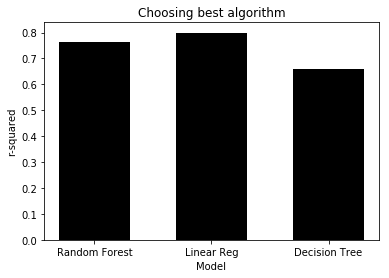

In [41]:
x = ['Random Forest', 'Linear Reg', 'Decision Tree']
y = np.array([forest_score, lin_score, tree_score])
plt.bar(x, y, color='k', width=0.6)
plt.title("Choosing best algorithm")
plt.xlabel("Model")
plt.ylabel("r-squared")
plt.show()

## Classification Modelling

In [42]:
main_df = df2[['cgpa', 'gre', 'toefl', 'accepted']]

In [43]:
X = main_df.drop('accepted', axis=1)
y = main_df['accepted']
col = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [44]:
X_train, X_test = scale_features(X_train, X_test, col)

In [45]:
def get_stats(tn, fp, fn, tp, all_stats=False):
    
    total = (tn + fp + fn + tp)
    freq_majority_class = (tn + fp) if (tn + fp) > (fn + tp) else (fn + tp)
    recall = tp/(fn + tp)
    precision = tp/(fp + tp)
    f1 = (precision*recall*2)/(precision + recall)
    
    if all_stats:
    
        print(f'''
        True Negative: {tn}, True Positive: {tp}, False Negative: {fn}, False Positive: {fp}

        Accuracy: {(tp + tn)/total}
        Misclassification Rate: {1 - (tp + tn)/total}
        True Positive Rate (Sensitivity/Recall): {recall}
        False Positive Rate: {fp/(tn+fp)}
        True Negative Rate: {tn/(tn + fp)}
        Precision: {precision}
        Prevalance: {(fn + tp)/total}
        Null error rate: {1 - (freq_majority_class/total)}
        f1 score: {f1}

        ''')
    
    else:
        
        print(f'''
        True Negative: {tn}, True Positive: {tp}, False Negative: {fn}, False Positive: {fp}
        
        True Positive Rate (Sensitivity/Recall): {recall}
        Precision: {precision}
        Prevalance: {(fn + tp)/total}
        Null error rate: {1 - (freq_majority_class/total)}
        f1 score: {f1}
        ''')
        
    return recall, precision, f1

### Forest

In [46]:
forest_clf = RandomForestClassifier(n_estimators=125, random_state=42)
forest_clf.fit(X_train, y_train)
pred = forest_clf.predict(X_test)
forest_score = accuracy_score(y_test, pred)
print(f"Accuracy: {forest_score}")

cm = confusion_matrix(y_test, pred).ravel()
tn, fp, fn, tp = cm

_, _, forest_f1 = get_stats(tn, fp, fn, tp)

res = pd.DataFrame()
res['Prediction'] = pred
res['Actual'] = np.array(y_test)
res.loc[::20]

Accuracy: 0.9266666666666666

        True Negative: 100, True Positive: 39, False Negative: 4, False Positive: 7
        
        True Positive Rate (Sensitivity/Recall): 0.9069767441860465
        Precision: 0.8478260869565217
        Prevalance: 0.2866666666666667
        Null error rate: 0.2866666666666666
        f1 score: 0.8764044943820224
        


,Prediction,Actual
0,1,1
20,0,0
40,1,1
60,0,0
80,0,1
100,1,0
120,0,0
140,1,0


### Logistic Regression

In [47]:
log_clf = LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr')
log_clf.fit(X_train, y_train)
pred = log_clf.predict(X_test)
log_score = accuracy_score(y_test, pred)
print(f"Accuracy: {log_score}")

cm = confusion_matrix(y_test, pred).ravel()
tn, fp, fn, tp = cm

_, _, log_f1 = get_stats(tn, fp, fn, tp)

res = pd.DataFrame()
res['Prediction'] = pred
res['Actual'] = np.array(y_test)
res.loc[::20]

Accuracy: 0.9266666666666666

        True Negative: 100, True Positive: 39, False Negative: 4, False Positive: 7
        
        True Positive Rate (Sensitivity/Recall): 0.9069767441860465
        Precision: 0.8478260869565217
        Prevalance: 0.2866666666666667
        Null error rate: 0.2866666666666666
        f1 score: 0.8764044943820224
        


,Prediction,Actual
0,1,1
20,0,0
40,1,1
60,0,0
80,0,1
100,0,0
120,0,0
140,1,0


### SVM

In [48]:
sv_clf = svm.SVC(random_state=42)
sv_clf.fit(X_train, y_train)
pred = sv_clf.predict(X_test)
sv_score = accuracy_score(y_test, pred)
print(f"Accuracy: {sv_score}")

cm = confusion_matrix(y_test, pred).ravel()
tn, fp, fn, tp = cm

_, _, sv_f1 = get_stats(tn, fp, fn, tp)

res = pd.DataFrame()
res['Prediction'] = pred
res['Actual'] = np.array(y_test)
res.loc[::20]

Accuracy: 0.9266666666666666

        True Negative: 99, True Positive: 40, False Negative: 3, False Positive: 8
        
        True Positive Rate (Sensitivity/Recall): 0.9302325581395349
        Precision: 0.8333333333333334
        Prevalance: 0.2866666666666667
        Null error rate: 0.2866666666666666
        f1 score: 0.8791208791208791
        


C:\Users\Aakash\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


,Prediction,Actual
0,1,1
20,0,0
40,1,1
60,0,0
80,0,1
100,0,0
120,0,0
140,1,0


### Decision Tree

In [49]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
pred = tree_clf.predict(X_test)
tree_score = accuracy_score(y_test, pred)
print(f"Accuracy: {tree_score}")

cm = confusion_matrix(y_test, pred).ravel()
tn, fp, fn, tp = cm

_, _, tree_f1 = get_stats(tn, fp, fn, tp)

res = pd.DataFrame()
res['Prediction'] = pred
res['Actual'] = np.array(y_test)
res.loc[::20]

Accuracy: 0.92

        True Negative: 101, True Positive: 37, False Negative: 6, False Positive: 6
        
        True Positive Rate (Sensitivity/Recall): 0.8604651162790697
        Precision: 0.8604651162790697
        Prevalance: 0.2866666666666667
        Null error rate: 0.2866666666666666
        f1 score: 0.8604651162790697
        


,Prediction,Actual
0,1,1
20,0,0
40,1,1
60,0,0
80,0,1
100,1,0
120,0,0
140,0,0


### Gaussian Naive Bayes

In [50]:
nb = GaussianNB()
nb.fit(X_train, y_train)
pred = nb.predict(X_test)
nb_score = accuracy_score(y_test, pred)
print(f"Accuracy: {nb_score}")

cm = confusion_matrix(y_test, pred).ravel()
tn, fp, fn, tp = cm

_, _, nb_f1 = get_stats(tn, fp, fn, tp)

res = pd.DataFrame()
res['Prediction'] = pred
res['Actual'] = np.array(y_test)
res.loc[::20]

Accuracy: 0.9133333333333333

        True Negative: 95, True Positive: 42, False Negative: 1, False Positive: 12
        
        True Positive Rate (Sensitivity/Recall): 0.9767441860465116
        Precision: 0.7777777777777778
        Prevalance: 0.2866666666666667
        Null error rate: 0.2866666666666666
        f1 score: 0.8659793814432991
        


,Prediction,Actual
0,1,1
20,0,0
40,1,1
60,0,0
80,1,1
100,1,0
120,0,0
140,1,0


## Comparing Classification Models

### By Accuracy

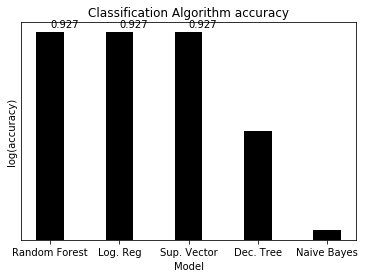

In [51]:
x = ['Random Forest', 'Log. Reg', 'Sup. Vector', 'Dec. Tree', 'Naive Bayes']
y = np.array([forest_score, log_score, sv_score, tree_score, nb_score])
plt.bar(x, y, color='k', width=0.4, log=True)

for a,b in zip(x, y):
    if b == y.max():
        b = round(b, 3)
        plt.text(a, b, str(b))
    
plt.title("Classification Algorithm accuracy")
plt.xlabel("Model")
plt.ylabel("log(accuracy)")
plt.show()

## By f1 score

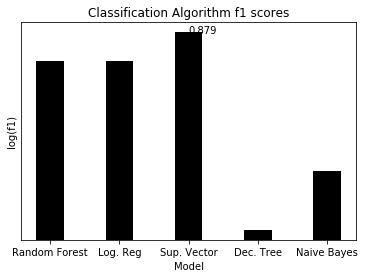

In [52]:
x = ['Random Forest', 'Log. Reg', 'Sup. Vector', 'Dec. Tree', 'Naive Bayes']
y = np.array([forest_f1, log_f1, sv_f1, tree_f1, nb_f1])
plt.bar(x, y, color='k', width=0.4, log=True)

for a,b in zip(x, y):
    if b == y.max():
        b = round(b, 3)
        plt.text(a, b, str(b))
    
plt.title("Classification Algorithm f1 scores")
plt.xlabel("Model")
plt.ylabel("log(f1)")
plt.show()

## Using final model for classification

In [53]:
X = main_df.drop('accepted', axis=1)
y = main_df['accepted']
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

pred = sv_clf.predict(X)
accuracy_score(y, pred)

0.914

In [54]:
final_df = pd.DataFrame(X, columns=col)
final_df['Prediction'] = pred
final_df['Actual'] = np.array(y)
final_df['is_correct'] = (final_df['Prediction'] == final_df['Actual'])

In [55]:
final_df.head()

,cgpa,gre,toefl,Prediction,Actual,is_correct
0,0.913462,0.94,0.928571,1,1,True
1,0.663462,0.68,0.535714,0,0,True
2,0.384615,0.52,0.428571,0,0,True
3,0.599359,0.64,0.642857,0,1,False
4,0.451923,0.48,0.392857,0,0,True


## Plotting the predictions

The __'O's__ represent correct prediction, __'X's__ represent incorrect prediction. Green plots are 'Accepted', Red are 'Rejected'.

The color of the __'X's__ represent the actual value. (eg. A green __'X'__ would mean that the correct value at that point is 'Accepted' which our model got wrong)

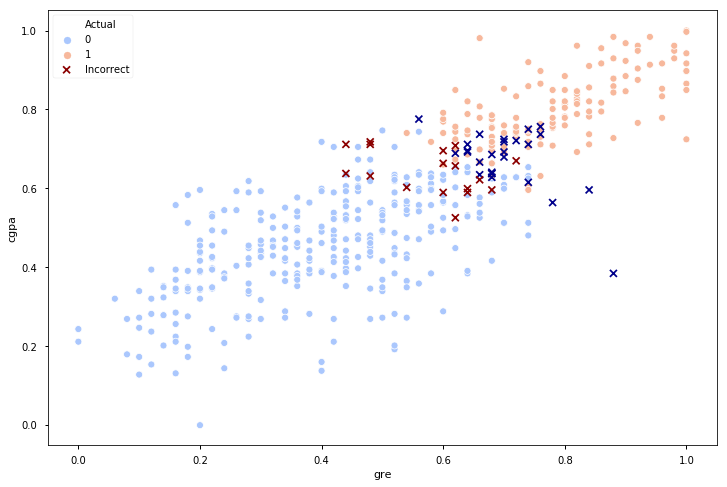

In [81]:
 with plt.style.context('seaborn-notebook'):
    plt.figure(figsize=(12, 8))
    ax = sns.scatterplot(data=final_df[final_df['is_correct']==True], x='gre', y='cgpa', hue='Actual', palette='coolwarm')

    colors = {1: 'darkred',
             0: 'darkblue'}

    incorrect = final_df[final_df['is_correct']==False]
    ax.scatter(x=incorrect['gre'], y=incorrect['cgpa'], marker='x', c=incorrect['Actual'].apply(lambda x: colors[x]), label='Incorrect')
    plt.legend()